In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [5]:
# Leer dataset
data = pd.read_excel("Data.xlsx")
# Vista rápida
data.head()
print("Información del DataFrame:")
data.info()
print("\nDescripción estadística del DataFrame:")
data.describe()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          100 non-null    int64  
 1   Class               100 non-null    object 
 2   age_years           100 non-null    float64
 3   sex                 100 non-null    object 
 4   BMI_kg_m2           100 non-null    float64
 5   systolic_BP_mmHg    100 non-null    int64  
 6   diastolic_BP_mmHg   100 non-null    int64  
 7   creatinine_mg_dL    100 non-null    float64
 8   eGFR_mL_min_1.73m2  100 non-null    int64  
 9   diabetes            100 non-null    object 
 10  smoking_status      100 non-null    object 
 11  proteinuria_g_day   100 non-null    float64
dtypes: float64(4), int64(4), object(4)
memory usage: 9.5+ KB

Descripción estadística del DataFrame:


,patient_id,age_years,BMI_kg_m2,systolic_BP_mmHg,diastolic_BP_mmHg,creatinine_mg_dL,eGFR_mL_min_1.73m2,proteinuria_g_day
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,50.500000,59.699000,27.363000,136.790000,85.07000,1.486300,60.160000,1.956500
std,29.011492,10.096109,4.205832,18.508145,10.31842,0.600935,25.976959,1.881398
min,1.000000,38.100000,15.700000,90.000000,59.00000,0.520000,16.000000,-0.030000
25%,25.750000,51.875000,24.800000,125.750000,77.00000,0.987500,37.750000,0.160000
50%,50.500000,59.950000,27.000000,136.000000,84.00000,1.365000,53.500000,1.790000
75%,75.250000,67.450000,29.400000,150.250000,92.25000,1.947500,81.250000,3.730000
max,100.000000,86.400000,40.600000,172.000000,107.00000,2.970000,121.000000,5.560000


### Como observamos, el dataframe tiene 100 registros y 12 columnas, sin registros nulos.
### La descripción estadística muestra las medidas de tendencia central y dispersión de las variables numéricas.

In [6]:
# Descripción univariada
# Separar variables continuas y categóricas
cont_vars = [
    'age_years',
    'BMI_kg_m2',
    'systolic_BP_mmHg',
    'diastolic_BP_mmHg',
    'creatinine_mg_dL',
    'eGFR_mL_min_1.73m2',
    'proteinuria_g_day'
]
cat_vars = [
    'Class',
    'sex',
    'diabetes',
    'smoking_status'
]

# Pruebas de normalidad y tabla resumen
normalidad = {}
desc_univariada = []

for var in cont_vars:
    shapiro_p = stats.shapiro(data[var].dropna()).pvalue
    if shapiro_p > 0.05:
        # Normal
        mean = data[var].mean()
        std = data[var].std()
        desc_univariada.append([var, 'Normal', f"{mean:.2f} ± {std:.2f}", shapiro_p])
    else:
        # No normal
        median = data[var].median()
        iqr = data[var].quantile(0.75) - data[var].quantile(0.25)
        desc_univariada.append([var, 'No normal', f"{median:.2f} [{iqr:.2f}]", shapiro_p])
    normalidad[var] = shapiro_p

df_desc = pd.DataFrame(desc_univariada, columns=['Variable','Distribución','Media±DE o Mediana [IQR]','Shapiro p'])
df_desc


,Variable,Distribución,Media±DE o Mediana [IQR],Shapiro p
0,age_years,Normal,59.70 ± 10.10,4.244302e-01
1,BMI_kg_m2,No normal,27.00 [4.60],1.505403e-02
2,systolic_BP_mmHg,Normal,136.79 ± 18.51,4.937344e-01
3,diastolic_BP_mmHg,Normal,85.07 ± 10.32,7.124015e-01
4,creatinine_mg_dL,No normal,1.37 [0.96],1.083615e-04
5,eGFR_mL_min_1.73m2,No normal,53.50 [43.50],4.094350e-04
6,proteinuria_g_day,No normal,1.79 [3.57],5.018059e-10


In [7]:
# Frecuencias categóricas
for var in cat_vars:
    freq_abs = data[var].value_counts()
    freq_rel = data[var].value_counts(normalize=True)*100
    df_freq = pd.DataFrame({'Frecuencia': freq_abs, 'Porcentaje': freq_rel.round(1)})
    print(f"\n{var}\n", df_freq)



Class
               Frecuencia  Porcentaje
Class                               
renal_damage          52        52.0
control               48        48.0

sex
         Frecuencia  Porcentaje
sex                           
Male            54        54.0
Female          46        46.0

diabetes
           Frecuencia  Porcentaje
diabetes                        
Yes               50        50.0
No                50        50.0

smoking_status
                 Frecuencia  Porcentaje
smoking_status                        
Never                   39        39.0
Current                 32        32.0
Former                  29        29.0


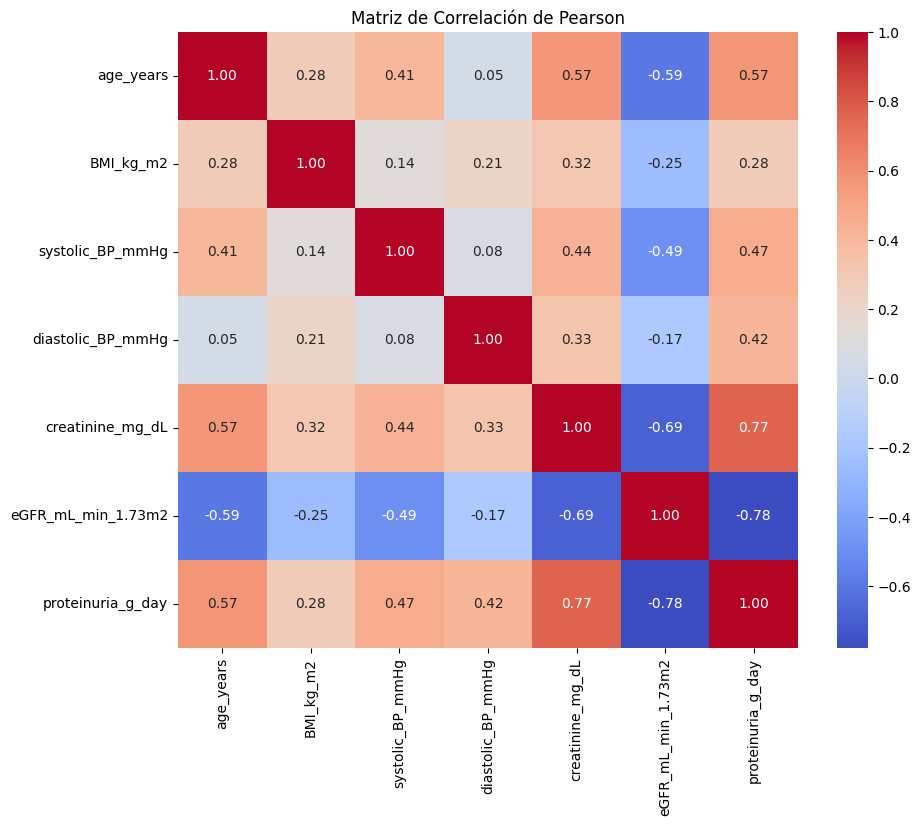

In [8]:
# Matriz de correlaciones
# Pearson para normales
corr_pearson = data[cont_vars].corr(method='pearson')

# Spearman para no normales
corr_spearman = data[cont_vars].corr(method='spearman')

# Ajuste de p-values para Pearson
pvals = pd.DataFrame(np.ones((len(cont_vars), len(cont_vars))), columns=cont_vars, index=cont_vars)

for i in cont_vars:
    for j in cont_vars:
        if i != j:
            pval = stats.pearsonr(data[i].dropna(), data[j].dropna())[1]
            pvals.loc[i,j] = pval

# Ajuste Bonferroni
pvals_adj = multipletests(pvals.values.flatten(), method='bonferroni')[1].reshape(pvals.shape)
pvals_adj_df = pd.DataFrame(pvals_adj, columns=cont_vars, index=cont_vars)

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlación de Pearson")
plt.show()


In [ ]:
# Pruebas de hipótesis
# Comparar creatinina entre fumadores actuales y nunca fumadores
grupo1 = data[data['smoking_status']=='Current']['creatinine_mg_dL']
grupo2 = data[data['smoking_status']=='Never']['creatinine_mg_dL']

# Según normalidad
if normalidad['creatinine_mg_dL'] > 0.05:
    test = stats.ttest_ind(grupo1, grupo2, nan_policy='omit')
    prueba = "t-test"
else:
    test = stats.mannwhitneyu(grupo1, grupo2)
    prueba = "Mann-Whitney"

print(f"{prueba} p-value: {test.pvalue:.4f}")


Mann-Whitney p-value: 0.0003


In [ ]:
# Pruebas Chi-cuadrado para categóricas sex y smoking_status
from scipy.stats import chi2_contingency

tabla = pd.crosstab(data['sex'], data['smoking_status'])
chi2, p, dof, expected = chi2_contingency(tabla)

print(f"Chi-cuadrado p-value: {p:.4f}")


Chi-cuadrado p-value: 0.0093


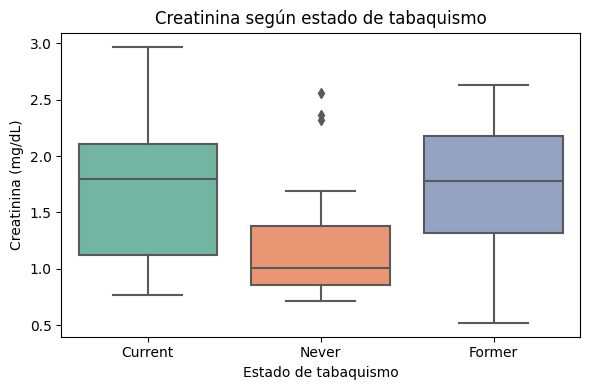

In [ ]:
#Creatinina y el tabaquismo
plt.figure(figsize=(6,4))
sns.boxplot(x='smoking_status', y='creatinine_mg_dL', data=data, palette='Set2')
plt.title('Creatinina según estado de tabaquismo')
plt.ylabel('Creatinina (mg/dL)')
plt.xlabel('Estado de tabaquismo')
plt.tight_layout()
plt.show()

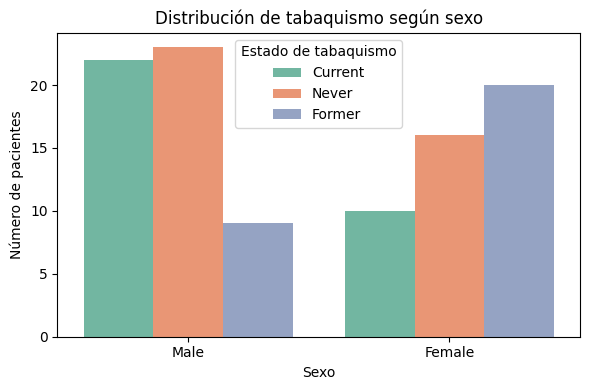

In [ ]:
#Sexo y el tabaquismo
plt.figure(figsize=(6,4))

# Gráfico de barras agrupadas
sns.countplot(data=data, x='sex', hue='smoking_status', palette='Set2')

# Títulos
plt.title('Distribución de tabaquismo según sexo')
plt.xlabel('Sexo')
plt.ylabel('Número de pacientes')

# Leyenda
plt.legend(title='Estado de tabaquismo')

plt.tight_layout()
plt.show()

In [ ]:
# Comparación de creatinina entre grupos de daño renal
grupo_control = data[data['Class']=='control']['creatinine_mg_dL'].dropna()
grupo_damage = data[data['Class']=='renal_damage']['creatinine_mg_dL'].dropna()


# Verifica normalidad con Shapiro-Wilk
sw_damage = stats.shapiro(grupo_damage)
sw_control = stats.shapiro(grupo_control)

print(f"Shapiro-Wilk p-value Damage: {sw_damage.pvalue:.4f}")
print(f"Shapiro-Wilk p-value Control: {sw_control.pvalue:.4f}")

# Según resultados
if sw_damage.pvalue > 0.05 and sw_control.pvalue > 0.05:
    # Verifica homogeneidad de varianzas
    levene_test = stats.levene(grupo_damage, grupo_control)
    print(f"Levene p-value: {levene_test.pvalue:.4f}")

    if levene_test.pvalue > 0.05:
        test = stats.ttest_ind(grupo_damage, grupo_control)
        prueba = "t-test"
    else:
        test = stats.ttest_ind(grupo_damage, grupo_control, equal_var=False)
        prueba = "t-test (varianzas desiguales)"
else:
    test = stats.mannwhitneyu(grupo_damage, grupo_control)
    prueba = "Mann-Whitney"

print(f"{prueba} p-value: {test.pvalue:.4f}")


Shapiro-Wilk p-value Damage: 0.9760
Shapiro-Wilk p-value Control: 0.6438
Levene p-value: 0.0000
t-test (varianzas desiguales) p-value: 0.0000


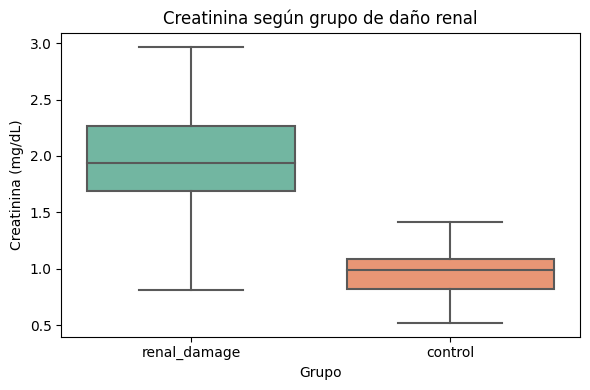

In [ ]:
#Visualizacion para grupos de daño renal con la variable creatinina
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='creatinine_mg_dL', data=data, palette='Set2')
plt.title('Creatinina según grupo de daño renal')
plt.ylabel('Creatinina (mg/dL)')
plt.xlabel('Grupo')
plt.tight_layout()
plt.show()


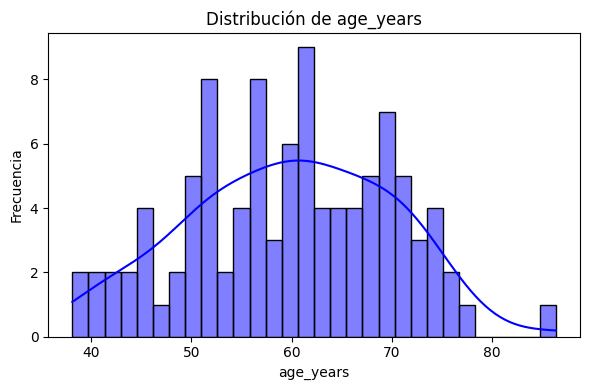

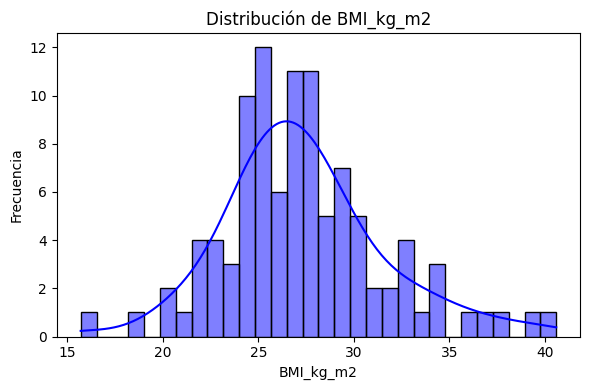

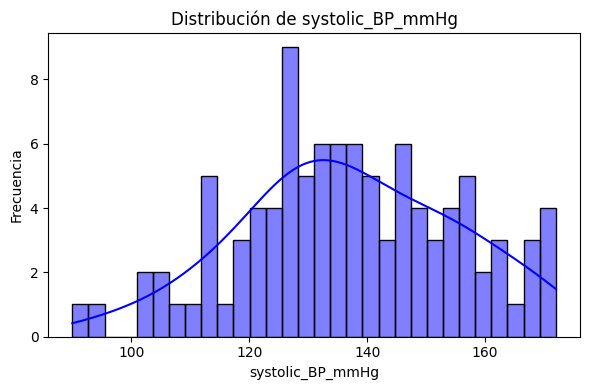

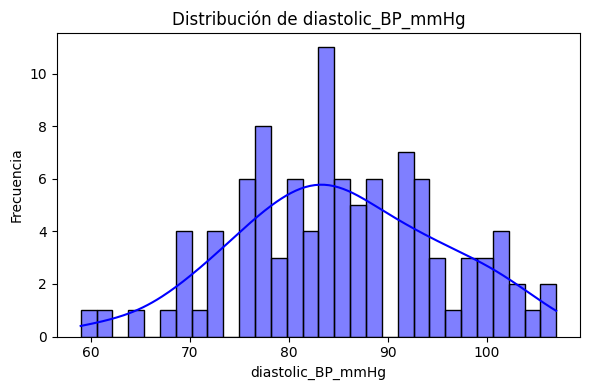

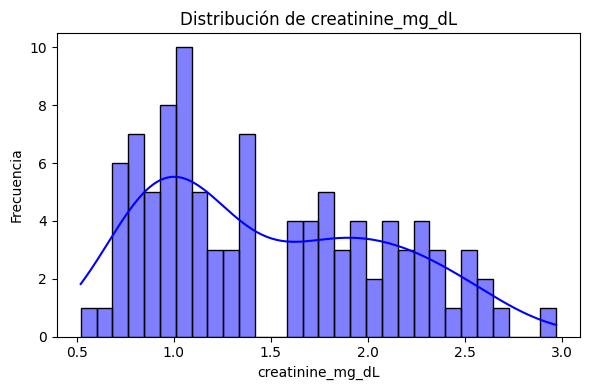

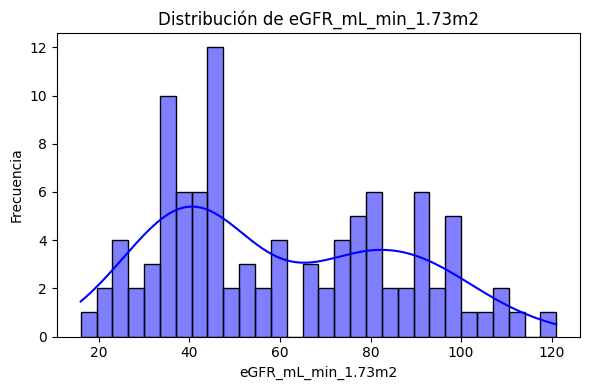

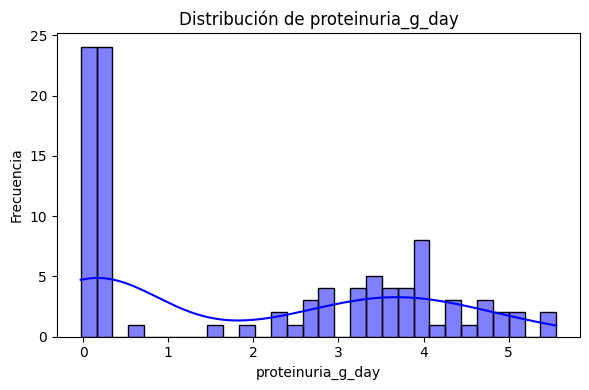

In [ ]:
#graficos distribuciones entre las variables
for var in cont_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(data[var].dropna(), kde=True, bins=30, color='blue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()